In [1]:
from typing import Tuple
import numpy as np
import deepgp
import matplotlib.pyplot as plt
from datetime import datetime
import os

import GPy
from GPy.models import GPRegression
from emukit.test_functions import forrester_function
from emukit.core.initial_designs import RandomDesign
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement, EntropySearch
from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.core.initial_designs import RandomDesign
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
from gpflow.kernels import RBF, White, Linear
from tqdm import tqdm

from simulator import MainSimulator, TinySimulator
from world import DebugInfo
from pprint import pprint

main_simulator = MainSimulator()

In [2]:
def plot_prediction(X,Y,x_plot,mu_plot,var_plot,axis):
    axis.plot(X, Y, "ro", markersize=10, label="Observations")
    axis.plot(x_plot[:, 0], mu_plot[:, 0], "C0", label="Model")
    axis.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
    axis.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
    axis.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
    axis.legend(loc=2, prop={'size': 10})
    axis.set(xlabel=r"$x$", ylabel=r"$f(x)$")
    axis.grid(True)

In [3]:
def plot_acquisition_functions(x_plot, ac_plot, x_new, axis):
    axis.plot(x_plot, (ac_plot[1] - np.min(ac_plot[1])) / (np.max(ac_plot[1]) - np.min(ac_plot[1])), label=ac_plot[0])
    #axis.plot(x_plot, (ac_plots[0][1] - np.min(ac_plots[0][1])) / (np.max(ac_plots[0][1]) - np.min(ac_plots[0][1])), label=ac_plots[0][0])
    #axis.plot(x_plot, (ac_plots[1][1] - np.min(ac_plots[1][1])) / (np.max(ac_plots[1][1]) - np.min(ac_plots[1][1])), label=ac_plots[1][0])
    #axis.plot(x_plot, (ac_plots[2][1] - np.min(ac_plots[2][1])) / (np.max(ac_plots[2][1]) - np.min(ac_plots[2][1])), label=ac_plots[2][0])
    #axis.plot(x_plot, (ac_plots[3][1] - np.min(ac_plots[3][1])) / (np.max(ac_plots[3][1]) - np.min(ac_plots[3][1])), label=ac_plots[3][0])

    axis.axvline(x_new, color="red", label="x_next", linestyle="--")
    axis.legend(loc=1, prop={'size': 10})
    axis.set(xlabel=r"$x$", ylabel=r"$f(x)$")
    axis.grid(True)

In [4]:
import statistics

def target_function_list(X, repetition=1):
    Y = []
    for x in X:
        mutation_rates = {
            "size": x[0],
            "speed": x[1],
            "vision": x[2],
            "aggression": x[3]
        }
        # items = []
        total = 0
        for i in range(repetition):
            days_survived, log = main_simulator.run(mutation_rates, debug_info=DebugInfo(
                period=10, should_display_day=False, should_display_grid=False, should_display_traits=False), max_days=10000)
            #items.append(days_survived)
            total += days_survived
        #Y.append(statistics.median(items))
        Y.append(total//repetition)
    return np.array(Y)[:,np.newaxis]

In [5]:
# Generate the initial points to start the training process

def experiment_initialisation(space, num_data_points = 5):
    design = RandomDesign(space) # Collect random points
    X = design.get_samples(num_data_points)
    Y = target_function_list(X)
    return X, Y

In [6]:
def model_generation(X, Y, space, kernel = None):
    if kernel is None:
        kernel_rbf_1 = GPy.kern.RBF(input_dim=1, lengthscale=0.1, variance=1, active_dims=[0])
        kernel_rbf_2 = GPy.kern.RBF(input_dim=1, lengthscale=0.1, variance=1, active_dims=[1])
        kernel_rbf_3 = GPy.kern.RBF(input_dim=1, lengthscale=0.1, variance=1, active_dims=[2])
        kernel_rbf_4 = GPy.kern.RBF(input_dim=1, lengthscale=0.1, variance=1, active_dims=[3])
        kernel = kernel_rbf_1 + kernel_rbf_2 + kernel_rbf_3 + kernel_rbf_4
    model_gpy = GPRegression(X,Y,kernel, noise_var=100) # Train and wrap the model in Emukit
    model_emukit = GPyModelWrapper(model_gpy)
    return model_emukit

In [15]:
iterations = 1000
# The other mutation rates for the projection
projection = 0
# Along which trait is the function plotted: 0-size, 1-speed, 2-vision, 3-aggression
plot = 0

# returns the mean square error history of the iterations
def train(model_emukit, X, Y, space, acquisition, iterations = 1000, plot = 0, projection = 0):

    file_path = 'training_logs/' + acquisition + '_plot_' + str(plot) + '_projection_' + str(projection) + '_' + str(datetime.now())
    os.makedirs(file_path)
    figure, axis = plt.subplots(1, 2, figsize=(20, 6))
    x_plot = np.linspace(0, 1, 1000)[:, None]
    x_paddings = np.linspace(projection, projection, 1000)[:, None]
    x_linear = np.linspace(0, 1, 1000)[:, None]

    history = []
    with open('dataset_test/mutation_rates.npy', 'rb') as f:
      X_test = np.load(f)
    with open('dataset_test/simulated_years_of_survival.npy', 'rb') as f:
      y_test = np.load(f)

    for j in range(plot):
        x_plot = np.append(x_paddings, x_plot, axis = 1)
    for j in range(3-plot):
        x_plot = np.append(x_plot, x_paddings, axis = 1)
    
    for i in tqdm(range(iterations)):
            
        mu_plot, var_plot = model_emukit.predict(x_plot)
        plot_prediction(X[:,plot],Y,x_linear,mu_plot,var_plot,axis[0])

        #acquisition = CrossEntropy(model_emukit,space)
        acquisition = ExpectedImprovement(model_emukit)
        #acquisition = ProbabilityOfImprovement(model_emukit)
        
        predictions, _ = model_emukit.predict(X_test)
        history.append(np.square(y_test + predictions).mean())
        
        ac_plot = ("AF", acquisition.evaluate(x_plot))
        
        optimizer = GradientAcquisitionOptimizer(space)
        x_new, _ = optimizer.optimize(acquisition)

        plot_acquisition_functions(x_linear, ac_plot, x_new[0][plot], axis[1])
        print("Next position to query:", x_new)
        #acquisition.debug(np.array(x_new))
        y_new = -target_function_list(x_new)
        X = np.append(X, x_new, axis=0)
        Y = np.append(Y, y_new, axis=0)
        print(x_new, y_new)
        #print('Prediction before set_data:', x_new, model_emukit.predict(np.array(x_new)))
        model_emukit.set_data(X, Y)
        #print('Prediction after set_data:', x_new, model_emukit.predict(np.array(x_new)))
        plt.savefig(file_path + '/' + str(i) +'.png')
        plt.clf()
        figure, axis = plt.subplots(1, 2, figsize=(20, 6))
        with open(file_path + '/history.npy', 'wb') as f:
            np.save(f, np.array(history))
    return history

In [60]:
def sensitivity_2d(X, sensitivity, x_a=0, y_a=1, projection = 0):
    results = []
    for x in X:
        point = np.array([projection, projection, projection, projection])
        point[x_a] = x[0]
        point[y_a] = x[1]
        results.append(sensitivity.compute_statistics(point)[0])
    return np.array(results)

In [ ]:
sensitivity = MonteCarloSensitivity(model = model_emukit, input_domain = space)
main_effects, total_effects, _ = sensitivity.compute_effects(num_monte_carlo_points = 10000)

In [251]:
def plot_sensitivity_2d(model_emukit, x_a=0, y_a=1, projection = 0):
    space = ParameterSpace([ContinuousParameter('size', 0, 1),
                        ContinuousParameter('speed', 0, 1),
                        ContinuousParameter('vision', 0, 1),
                        ContinuousParameter('aggression', 0, 1)])
    
    sensitivity = MonteCarloSensitivity(model = model_emukit, input_domain = space)
    main_effects, total_effects, _ = sensitivity.compute_effects(num_monte_carlo_points = 10000)
    
    x_axis = np.linspace(0, 1, 100)
    y_axis = np.linspace(0, 1, 100)
    
    X_axis,Y_axis = np.meshgrid(x_axis, y_axis)
    data = np.vstack([X_axis.ravel(), Y_axis.ravel()])
    data = np.swapaxes(data,0,-1)
    
    plt.figure(figsize=(8,6))
    plt.contourf(X_axis, Y_axis, sensitivity_2d(data, sensitivity, x_a, y_a, projection).reshape(X_axis.shape), levels=20)
    plt.colorbar()
    return main_effects, total_effects

In [8]:
space = ParameterSpace([ContinuousParameter('size', 0, 1),
                            ContinuousParameter('speed', 0, 1),
                            ContinuousParameter('vision', 0, 1),
                            ContinuousParameter('aggression', 0, 1)])
kernel = GPy.kern.Matern32(input_dim=4, lengthscale=0.1, variance=300)
X, Y = experiment_initialisation(space,5)

In [ ]:
Y_ne = -Y
model = model_generation(X, Y_ne, space)
model.optimize()
ce_acquisition = CrossEntropy(model,space)
es_history = train(model, X, Y_ne, space, 'EI', 200)

  0%|                                                                                                                                                     | 0/200 [00:00<?, ?it/s] /Users/zoeytxc/.pyenv/versions/3.10.13/lib/python3.10/site-packages/GPy/kern/src/stationary.py:353: RuntimeWarning:invalid value encountered in divide


Next position to query: [[0.99646914 0.0040257  0.05761391 0.88381023]]
[[0.99646914 0.0040257  0.05761391 0.88381023]] [[-1820]]


  0%|▋                                                                                                                                          | 1/200 [00:53<2:58:17, 53.76s/it]

Next position to query: [[0.89333047 0.00115771 0.35543013 0.64494111]]


  1%|█▍                                                                                                                                         | 2/200 [01:46<2:56:03, 53.35s/it]

[[0.89333047 0.00115771 0.35543013 0.64494111]] [[-1628]]
Next position to query: [[0.90554823 0.00411453 0.81894615 0.01082922]]


  2%|██                                                                                                                                         | 3/200 [02:49<3:08:45, 57.49s/it]

[[0.90554823 0.00411453 0.81894615 0.01082922]] [[-1721]]
Next position to query: [[0.68825483 0.00203967 0.03122175 0.99520632]]
[[0.68825483 0.00203967 0.03122175 0.99520632]] [[-1627]]


  2%|██▊                                                                                                                                        | 4/200 [03:40<2:59:15, 54.88s/it]

Next position to query: [[7.93820842e-01 2.86794012e-05 2.73441961e-01 4.54199885e-02]]


  2%|███▍                                                                                                                                       | 5/200 [04:47<3:12:27, 59.22s/it]

[[7.93820842e-01 2.86794012e-05 2.73441961e-01 4.54199885e-02]] [[-1731]]
Next position to query: [[8.17932511e-01 1.86114093e-04 7.51299515e-01 5.75050865e-01]]
[[8.17932511e-01 1.86114093e-04 7.51299515e-01 5.75050865e-01]] [[-1645]]


  3%|████▏                                                                                                                                      | 6/200 [05:40<3:04:46, 57.15s/it]

Next position to query: [[0.99065156 0.00824894 0.51307773 0.2412551 ]]
[[0.99065156 0.00824894 0.51307773 0.2412551 ]] [[-1732]]


  4%|████▊                                                                                                                                      | 7/200 [06:37<3:03:59, 57.20s/it]

Next position to query: [[6.97681275e-01 5.18354116e-04 8.96253761e-01 6.38331657e-02]]
[[6.97681275e-01 5.18354116e-04 8.96253761e-01 6.38331657e-02]] [[-1943]]


  4%|█████▌                                                                                                                                     | 8/200 [07:45<3:14:04, 60.65s/it]

Next position to query: [[0.94199068 0.00382105 0.88085359 0.30010401]]
[[0.94199068 0.00382105 0.88085359 0.30010401]] [[-1623]]


  4%|██████▎                                                                                                                                    | 9/200 [08:39<3:06:54, 58.71s/it]

Next position to query: [[3.29555487e-01 8.13703226e-05 1.87964467e-01 4.33664786e-01]]
[[3.29555487e-01 8.13703226e-05 1.87964467e-01 4.33664786e-01]] [[-1838]]


  5%|██████▉                                                                                                                                   | 10/200 [09:56<3:23:30, 64.26s/it]

Next position to query: [[0.53678025 0.00231919 0.19174707 0.20139967]]
[[0.53678025 0.00231919 0.19174707 0.20139967]] [[-1732]]


  6%|███████▌                                                                                                                                  | 11/200 [11:06<3:27:52, 65.99s/it]

Next position to query: [[0.97131389 0.00248667 0.90043476 0.25044096]]
[[0.97131389 0.00248667 0.90043476 0.25044096]] [[-1737]]


  6%|████████▎                                                                                                                                 | 12/200 [12:03<3:17:41, 63.09s/it]

Next position to query: [[0.95603854 0.00635561 0.0194565  0.11947768]]
[[0.95603854 0.00635561 0.0194565  0.11947768]] [[-1635]]


  6%|████████▉                                                                                                                                 | 13/200 [13:05<3:15:37, 62.77s/it]

Next position to query: [[0.96580388 0.00221553 0.61263241 0.00970699]]
[[0.96580388 0.00221553 0.61263241 0.00970699]] [[-1645]]


  7%|█████████▋                                                                                                                                | 14/200 [14:12<3:18:57, 64.18s/it]

Next position to query: [[0.05967355 0.00199527 0.57056122 0.15581121]]
[[0.05967355 0.00199527 0.57056122 0.15581121]] [[-1722]]


  8%|██████████▎                                                                                                                               | 15/200 [15:39<3:39:07, 71.07s/it]

Next position to query: [[0.71395439 0.00194886 0.52026082 0.00387363]]
[[0.71395439 0.00194886 0.52026082 0.00387363]] [[-1735]]


  8%|███████████                                                                                                                               | 16/200 [16:34<3:23:08, 66.24s/it]

Next position to query: [[0.01865574 0.00406635 0.9113302  0.09235041]]
[[0.01865574 0.00406635 0.9113302  0.09235041]] [[-2029]]


  8%|███████████▋                                                                                                                              | 17/200 [18:05<3:44:22, 73.56s/it]

Next position to query: [[0.02794283 0.00598531 0.88663085 0.29774423]]
[[0.02794283 0.00598531 0.88663085 0.29774423]] [[-1921]]


  9%|████████████▍                                                                                                                             | 18/200 [19:36<3:59:21, 78.91s/it]

Next position to query: [[0.17050042 0.01081926 0.63421474 0.11384015]]
[[0.17050042 0.01081926 0.63421474 0.11384015]] [[-1731]]


 10%|█████████████                                                                                                                             | 19/200 [20:52<3:55:05, 77.93s/it]

Next position to query: [[1.14822578e-01 4.45791478e-04 5.71649955e-01 4.07936613e-02]]
[[1.14822578e-01 4.45791478e-04 5.71649955e-01 4.07936613e-02]] [[-1729]]


 /var/folders/8p/rl0cc1cx5h5301dxt0kcg54h0000gn/T/ipykernel_19564/3380609783.py:57: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
 10%|█████████████▊                                                                                                                            | 20/200 [22:24<4:06:21, 82.12s/it]

Next position to query: [[0.1395238  0.00280488 0.88428748 0.39753203]]
[[0.1395238  0.00280488 0.88428748 0.39753203]] [[-1926]]


 10%|██████████████▍                                                                                                                           | 21/200 [23:43<4:02:27, 81.27s/it]

Next position to query: [[0.02696816 0.00215482 0.81007702 0.50730789]]
[[0.02696816 0.00215482 0.81007702 0.50730789]] [[-1827]]


 11%|███████████████▏                                                                                                                          | 22/200 [25:09<4:05:05, 82.62s/it]

Next position to query: [[0.08864347 0.00264135 0.83471999 0.28099262]]
[[0.08864347 0.00264135 0.83471999 0.28099262]] [[-1731]]


 12%|███████████████▊                                                                                                                          | 23/200 [26:29<4:01:28, 81.86s/it]

Next position to query: [[0.08547712 0.00096808 0.21273463 0.19721237]]
[[0.08547712 0.00096808 0.21273463 0.19721237]] [[-1640]]


 12%|████████████████▌                                                                                                                         | 24/200 [27:49<3:58:35, 81.34s/it]

Next position to query: [[0.16438678 0.0047856  0.80376303 0.30983466]]
[[0.16438678 0.0047856  0.80376303 0.30983466]] [[-1729]]


 12%|█████████████████▎                                                                                                                        | 25/200 [29:02<3:50:06, 78.89s/it]

Next position to query: [[0.04493011 0.00570436 0.64856844 0.66927084]]
[[0.04493011 0.00570436 0.64856844 0.66927084]] [[-1729]]


 13%|█████████████████▉                                                                                                                        | 26/200 [30:26<3:52:52, 80.30s/it]

Next position to query: [[2.02726033e-01 7.32816341e-04 7.75747407e-01 4.53073402e-01]]
[[2.02726033e-01 7.32816341e-04 7.75747407e-01 4.53073402e-01]] [[-1735]]


 14%|██████████████████▋                                                                                                                       | 27/200 [31:39<3:45:13, 78.11s/it]

Next position to query: [[0.02192917 0.00343862 0.16956395 0.46036983]]
[[0.02192917 0.00343862 0.16956395 0.46036983]] [[-1625]]


 14%|███████████████████▎                                                                                                                      | 28/200 [33:09<3:54:14, 81.71s/it]

Next position to query: [[0.04123563 0.00721858 0.47719831 0.11792986]]
[[0.04123563 0.00721858 0.47719831 0.11792986]] [[-1832]]


 14%|████████████████████                                                                                                                      | 29/200 [34:40<4:01:08, 84.61s/it]

Next position to query: [[0.1209484  0.00182891 0.78481993 0.21544065]]
[[0.1209484  0.00182891 0.78481993 0.21544065]] [[-1726]]


 15%|████████████████████▋                                                                                                                     | 30/200 [35:57<3:53:27, 82.40s/it]

Next position to query: [[0.27820956 0.00256159 0.65444891 0.22233123]]
[[0.27820956 0.00256159 0.65444891 0.22233123]] [[-1734]]


 16%|█████████████████████▍                                                                                                                    | 31/200 [37:06<3:40:51, 78.41s/it]

Next position to query: [[0.16115    0.00231124 0.851462   0.52687641]]
[[0.16115    0.00231124 0.851462   0.52687641]] [[-1938]]


 16%|██████████████████████                                                                                                                    | 32/200 [38:25<3:39:32, 78.41s/it]

Next position to query: [[1.06273040e-01 7.12447559e-05 9.66331041e-01 6.70826085e-01]]
[[1.06273040e-01 7.12447559e-05 9.66331041e-01 6.70826085e-01]] [[-1725]]


 16%|██████████████████████▊                                                                                                                   | 33/200 [39:52<3:45:14, 80.92s/it]

Next position to query: [[0.24825248 0.00179059 0.74405899 0.55033194]]
[[0.24825248 0.00179059 0.74405899 0.55033194]] [[-1833]]


 17%|███████████████████████▍                                                                                                                  | 34/200 [41:07<3:39:17, 79.26s/it]

Next position to query: [[0.09692859 0.00690368 0.29137721 0.40822852]]
[[0.09692859 0.00690368 0.29137721 0.40822852]] [[-1738]]


 18%|████████████████████████▏                                                                                                                 | 35/200 [42:40<3:49:23, 83.41s/it]

Next position to query: [[0.14255425 0.00656942 0.68004218 0.49275282]]
[[0.14255425 0.00656942 0.68004218 0.49275282]] [[-1827]]


 18%|████████████████████████▊                                                                                                                 | 36/200 [44:04<3:48:45, 83.69s/it]

Next position to query: [[0.11071688 0.00423792 0.77153299 0.05126953]]
[[0.11071688 0.00423792 0.77153299 0.05126953]] [[-1734]]


 18%|█████████████████████████▌                                                                                                                | 37/200 [45:39<3:56:13, 86.95s/it]

Next position to query: [[0.04154109 0.00549545 0.03901255 0.3882748 ]]
[[0.04154109 0.00549545 0.03901255 0.3882748 ]] [[-1734]]


 19%|██████████████████████████▏                                                                                                               | 38/200 [47:11<3:58:59, 88.52s/it]

Next position to query: [[0.16167906 0.00106772 0.01147571 0.6561616 ]]
[[0.16167906 0.00106772 0.01147571 0.6561616 ]] [[-1827]]


 20%|██████████████████████████▉                                                                                                               | 39/200 [48:37<3:55:12, 87.65s/it]

Next position to query: [[0.0710774  0.00225512 0.90599261 0.32827028]]
[[0.0710774  0.00225512 0.90599261 0.32827028]] [[-1631]]


 20%|███████████████████████████▌                                                                                                              | 40/200 [50:11<3:59:15, 89.72s/it]

Next position to query: [[0.0999102  0.00296273 0.94073898 0.75718743]]
[[0.0999102  0.00296273 0.94073898 0.75718743]] [[-2029]]


 20%|████████████████████████████▎                                                                                                             | 41/200 [51:38<3:55:20, 88.81s/it]

Next position to query: [[0.09053227 0.01049444 0.12543365 0.71320981]]
[[0.09053227 0.01049444 0.12543365 0.71320981]] [[-1920]]


 21%|████████████████████████████▉                                                                                                             | 42/200 [53:09<3:55:58, 89.61s/it]

Next position to query: [[0.08882763 0.00053064 0.34872363 0.50209219]]
[[0.08882763 0.00053064 0.34872363 0.50209219]] [[-1727]]


 22%|█████████████████████████████▋                                                                                                            | 43/200 [54:41<3:55:59, 90.19s/it]

Next position to query: [[8.33907611e-02 7.45026346e-05 8.03213947e-01 9.66875934e-01]]
[[8.33907611e-02 7.45026346e-05 8.03213947e-01 9.66875934e-01]] [[-2020]]


 22%|██████████████████████████████▎                                                                                                           | 44/200 [56:08<3:52:17, 89.34s/it]

Next position to query: [[3.75442960e-02 9.52042635e-04 9.77751622e-01 8.16529116e-01]]
[[3.75442960e-02 9.52042635e-04 9.77751622e-01 8.16529116e-01]] [[-1936]]


 22%|███████████████████████████████                                                                                                           | 45/200 [57:41<3:53:17, 90.30s/it]

Next position to query: [[8.51165193e-02 2.70677848e-04 3.01985336e-01 8.78546657e-01]]
[[8.51165193e-02 2.70677848e-04 3.01985336e-01 8.78546657e-01]] [[-1728]]


 23%|███████████████████████████████▋                                                                                                          | 46/200 [59:25<4:02:01, 94.29s/it]

Next position to query: [[0.04371585 0.00192223 0.91024356 0.97779444]]
[[0.04371585 0.00192223 0.91024356 0.97779444]] [[-1734]]


 24%|███████████████████████████████▉                                                                                                        | 47/200 [1:01:06<4:05:52, 96.42s/it]

Next position to query: [[0.22111667 0.00114619 0.5014447  0.50618455]]
[[0.22111667 0.00114619 0.5014447  0.50618455]] [[-1829]]


 24%|████████████████████████████████▋                                                                                                       | 48/200 [1:02:40<4:02:18, 95.65s/it]

Next position to query: [[0.00449523 0.00376923 0.96521547 0.610248  ]]
[[0.00449523 0.00376923 0.96521547 0.610248  ]] [[-1733]]


 24%|█████████████████████████████████▎                                                                                                      | 49/200 [1:03:52<3:43:19, 88.74s/it]

Next position to query: [[2.34911763e-01 7.75874729e-06 2.55882327e-01 5.27179715e-02]]
[[2.34911763e-01 7.75874729e-06 2.55882327e-01 5.27179715e-02]] [[-1825]]


 25%|██████████████████████████████████                                                                                                      | 50/200 [1:05:20<3:40:52, 88.35s/it]

Next position to query: [[0.05247141 0.00377574 0.09028333 0.80280359]]
[[0.05247141 0.00377574 0.09028333 0.80280359]] [[-1724]]


 26%|██████████████████████████████████▋                                                                                                     | 51/200 [1:06:50<3:40:53, 88.95s/it]

Next position to query: [[0.19495468 0.00248919 0.19419939 0.99975726]]
[[0.19495468 0.00248919 0.19419939 0.99975726]] [[-1831]]


 26%|███████████████████████████████████▎                                                                                                    | 52/200 [1:08:13<3:34:43, 87.05s/it]

Next position to query: [[0.06360889 0.00135989 0.46342866 0.72816324]]
[[0.06360889 0.00135989 0.46342866 0.72816324]] [[-1733]]


 26%|████████████████████████████████████                                                                                                    | 53/200 [1:09:39<3:32:55, 86.90s/it]

Next position to query: [[0.16827539 0.00391502 0.752834   0.69365412]]
[[0.16827539 0.00391502 0.752834   0.69365412]] [[-1831]]


 27%|████████████████████████████████████▋                                                                                                   | 54/200 [1:10:57<3:24:53, 84.20s/it]

Next position to query: [[1.65031882e-01 8.95326522e-04 2.49746683e-01 9.53578858e-01]]
[[1.65031882e-01 8.95326522e-04 2.49746683e-01 9.53578858e-01]] [[-1830]]


 28%|█████████████████████████████████████▍                                                                                                  | 55/200 [1:12:16<3:19:33, 82.58s/it]

Next position to query: [[0.08056157 0.00348209 0.91289711 0.22515202]]
[[0.08056157 0.00348209 0.91289711 0.22515202]] [[-1737]]


 28%|██████████████████████████████████████                                                                                                  | 56/200 [1:13:47<3:23:51, 84.94s/it]

Next position to query: [[0.02638281 0.00577403 0.83700387 0.00606344]]
[[0.02638281 0.00577403 0.83700387 0.00606344]] [[-1838]]


 28%|██████████████████████████████████████▊                                                                                                 | 57/200 [1:15:14<3:24:10, 85.67s/it]

Next position to query: [[0.0777389  0.00638526 0.80453333 0.17894432]]
[[0.0777389  0.00638526 0.80453333 0.17894432]] [[-1734]]


 29%|███████████████████████████████████████▍                                                                                                | 58/200 [1:16:48<3:28:36, 88.15s/it]

Next position to query: [[2.85429412e-02 1.76958890e-04 5.21689197e-01 3.87798470e-01]]
[[2.85429412e-02 1.76958890e-04 5.21689197e-01 3.87798470e-01]] [[-1720]]


 30%|████████████████████████████████████████                                                                                                | 59/200 [1:18:32<3:38:12, 92.85s/it]

Next position to query: [[0.22691645 0.00850906 0.89350723 0.83669571]]
[[0.22691645 0.00850906 0.89350723 0.83669571]] [[-1731]]


 30%|████████████████████████████████████████▊                                                                                               | 60/200 [1:19:46<3:23:38, 87.27s/it]

Next position to query: [[0.14262521 0.00818791 0.85033756 0.97814102]]
[[0.14262521 0.00818791 0.85033756 0.97814102]] [[-1733]]


 30%|█████████████████████████████████████████▍                                                                                              | 61/200 [1:21:04<3:15:51, 84.55s/it]

Next position to query: [[0.16056838 0.00789049 0.92842702 0.8574477 ]]
[[0.16056838 0.00789049 0.92842702 0.8574477 ]] [[-1626]]


 31%|██████████████████████████████████████████▏                                                                                             | 62/200 [1:22:20<3:08:15, 81.85s/it]

Next position to query: [[0.2339282  0.00106782 0.45331027 0.50713059]]
[[0.2339282  0.00106782 0.45331027 0.50713059]] [[-1728]]


 32%|██████████████████████████████████████████▊                                                                                             | 63/200 [1:23:46<3:09:39, 83.06s/it]

Next position to query: [[4.88697275e-02 5.97517079e-04 4.65353285e-01 8.19694068e-01]]
[[4.88697275e-02 5.97517079e-04 4.65353285e-01 8.19694068e-01]] [[-1832]]


 32%|███████████████████████████████████████████▌                                                                                            | 64/200 [1:25:31<3:23:31, 89.79s/it]

Next position to query: [[0.08151643 0.00187417 0.17331158 0.1409788 ]]
[[0.08151643 0.00187417 0.17331158 0.1409788 ]] [[-1731]]


 32%|████████████████████████████████████████████▏                                                                                           | 65/200 [1:27:15<3:31:53, 94.18s/it]

Next position to query: [[1.06581205e-01 5.01800890e-04 8.12298616e-01 7.32703476e-01]]
[[1.06581205e-01 5.01800890e-04 8.12298616e-01 7.32703476e-01]] [[-1925]]


 33%|████████████████████████████████████████████▉                                                                                           | 66/200 [1:28:52<3:31:46, 94.82s/it]

Next position to query: [[0.1484678  0.01297707 0.40911611 0.98376724]]
[[0.1484678  0.01297707 0.40911611 0.98376724]] [[-1728]]


 34%|█████████████████████████████████████████████▌                                                                                          | 67/200 [1:30:14<3:21:51, 91.06s/it]

Next position to query: [[0.10431373 0.00503515 0.85169382 0.63958138]]
[[0.10431373 0.00503515 0.85169382 0.63958138]] [[-1638]]


 34%|██████████████████████████████████████████████▏                                                                                         | 68/200 [1:31:37<3:14:47, 88.54s/it]

Next position to query: [[0.00892286 0.00115591 0.42227956 0.13212833]]
[[0.00892286 0.00115591 0.42227956 0.13212833]] [[-1925]]


 34%|██████████████████████████████████████████████▉                                                                                         | 69/200 [1:33:17<3:20:47, 91.96s/it]

Next position to query: [[0.0167073  0.00369939 0.04905395 0.82908193]]
[[0.0167073  0.00369939 0.04905395 0.82908193]] [[-1730]]


 35%|███████████████████████████████████████████████▌                                                                                        | 70/200 [1:34:48<3:19:02, 91.87s/it]

Next position to query: [[0.09752639 0.00609294 0.23878885 0.89931731]]
[[0.09752639 0.00609294 0.23878885 0.89931731]] [[-1830]]


 36%|████████████████████████████████████████████████▎                                                                                       | 71/200 [1:36:39<3:29:26, 97.41s/it]

Next position to query: [[2.50132248e-01 2.35120423e-04 3.99806713e-01 5.21501137e-01]]
[[2.50132248e-01 2.35120423e-04 3.99806713e-01 5.21501137e-01]] [[-1731]]


 36%|████████████████████████████████████████████████▉                                                                                       | 72/200 [1:38:16<3:27:27, 97.25s/it]

Next position to query: [[0.0811344  0.01031393 0.3983511  0.19644516]]
[[0.0811344  0.01031393 0.3983511  0.19644516]] [[-1531]]


 36%|█████████████████████████████████████████████████▋                                                                                      | 73/200 [1:39:48<3:23:02, 95.93s/it]

Next position to query: [[0.04988205 0.00766395 0.19871954 0.75560164]]
[[0.04988205 0.00766395 0.19871954 0.75560164]] [[-1629]]


 37%|██████████████████████████████████████████████████▎                                                                                     | 74/200 [1:41:25<3:21:56, 96.16s/it]

Next position to query: [[5.87825777e-02 1.65442628e-04 1.48557195e-01 4.73696144e-01]]
[[5.87825777e-02 1.65442628e-04 1.48557195e-01 4.73696144e-01]] [[-1724]]


 38%|███████████████████████████████████████████████████                                                                                     | 75/200 [1:43:09<3:25:24, 98.60s/it]

Next position to query: [[0.1010886  0.0033062  0.6387942  0.59352684]]
[[0.1010886  0.0033062  0.6387942  0.59352684]] [[-1724]]


 38%|███████████████████████████████████████████████████▋                                                                                    | 76/200 [1:44:40<3:18:36, 96.10s/it]

Next position to query: [[1.18027715e-01 1.16057961e-04 4.10079047e-01 7.07778828e-01]]
[[1.18027715e-01 1.16057961e-04 4.10079047e-01 7.07778828e-01]] [[-1532]]


 38%|████████████████████████████████████████████████████▎                                                                                   | 77/200 [1:46:07<3:11:43, 93.52s/it]

Next position to query: [[0.02305395 0.00062557 0.49550681 0.26707832]]
[[0.02305395 0.00062557 0.49550681 0.26707832]] [[-1828]]


 39%|█████████████████████████████████████████████████████                                                                                   | 78/200 [1:48:02<3:22:54, 99.79s/it]

Next position to query: [[7.25058466e-02 6.91595532e-04 7.79241588e-01 1.20336714e-01]]
[[7.25058466e-02 6.91595532e-04 7.79241588e-01 1.20336714e-01]] [[-1728]]


 40%|█████████████████████████████████████████████████████▎                                                                                 | 79/200 [1:49:45<3:23:15, 100.79s/it]

Next position to query: [[0.24102481 0.00191385 0.76932172 0.62746294]]
[[0.24102481 0.00191385 0.76932172 0.62746294]] [[-1732]]


 40%|██████████████████████████████████████████████████████▍                                                                                 | 80/200 [1:51:08<3:11:09, 95.58s/it]

Next position to query: [[0.1531047  0.0090762  0.23909674 0.84317045]]
[[0.1531047  0.0090762  0.23909674 0.84317045]] [[-1833]]


 40%|███████████████████████████████████████████████████████                                                                                 | 81/200 [1:52:37<3:05:49, 93.69s/it]

Next position to query: [[8.31943965e-02 8.30825345e-04 9.64207171e-01 9.94722450e-01]]
[[8.31943965e-02 8.30825345e-04 9.64207171e-01 9.94722450e-01]] [[-1924]]


 41%|███████████████████████████████████████████████████████▊                                                                                | 82/200 [1:54:09<3:03:17, 93.20s/it]

Next position to query: [[0.21530109 0.00255795 0.65459594 0.88214393]]
[[0.21530109 0.00255795 0.65459594 0.88214393]] [[-1732]]


 42%|████████████████████████████████████████████████████████▍                                                                               | 83/200 [1:55:34<2:56:43, 90.63s/it]

Next position to query: [[0.10435612 0.00157448 0.73884477 0.35234129]]
[[0.10435612 0.00157448 0.73884477 0.35234129]] [[-1828]]


 42%|█████████████████████████████████████████████████████████                                                                               | 84/200 [1:57:12<2:59:20, 92.77s/it]

Next position to query: [[0.03503492 0.00247216 0.66992164 0.76611953]]
[[0.03503492 0.00247216 0.66992164 0.76611953]] [[-1631]]


 42%|█████████████████████████████████████████████████████████▊                                                                              | 85/200 [1:58:55<3:03:40, 95.83s/it]

Next position to query: [[0.24852449 0.00131522 0.29739499 0.60673662]]
[[0.24852449 0.00131522 0.29739499 0.60673662]] [[-1841]]


 43%|██████████████████████████████████████████████████████████▍                                                                             | 86/200 [2:00:32<3:02:56, 96.28s/it]

Next position to query: [[0.04836924 0.00412015 0.66178337 0.56794893]]
[[0.04836924 0.00412015 0.66178337 0.56794893]] [[-1634]]


 44%|███████████████████████████████████████████████████████████▏                                                                            | 87/200 [2:02:14<3:04:20, 97.88s/it]

Next position to query: [[0.01920938 0.01125264 0.14099341 0.96565001]]
[[0.01920938 0.01125264 0.14099341 0.96565001]] [[-1917]]


 44%|███████████████████████████████████████████████████████████▍                                                                           | 88/200 [2:04:02<3:08:40, 101.07s/it]

Next position to query: [[0.03299349 0.0060027  0.09629199 0.84587211]]
[[0.03299349 0.0060027  0.09629199 0.84587211]] [[-1837]]


 44%|████████████████████████████████████████████████████████████                                                                           | 89/200 [2:05:49<3:10:10, 102.80s/it]

Next position to query: [[0.18185223 0.00227733 0.83778221 0.94163465]]
[[0.18185223 0.00227733 0.83778221 0.94163465]] [[-1737]]


 45%|█████████████████████████████████████████████████████████████▏                                                                          | 90/200 [2:07:17<3:00:05, 98.23s/it]

Next position to query: [[0.03900802 0.00773221 0.73962404 0.14237372]]
[[0.03900802 0.00773221 0.73962404 0.14237372]] [[-1727]]


 46%|█████████████████████████████████████████████████████████████▉                                                                          | 91/200 [2:08:54<2:57:53, 97.92s/it]

Next position to query: [[0.15995562 0.00261465 0.91355861 0.4196362 ]]
[[0.15995562 0.00261465 0.91355861 0.4196362 ]] [[-1923]]


 46%|██████████████████████████████████████████████████████████████▌                                                                         | 92/200 [2:10:23<2:51:18, 95.17s/it]

Next position to query: [[0.02114125 0.00577038 0.27913339 0.34127523]]
[[0.02114125 0.00577038 0.27913339 0.34127523]] [[-1831]]


 46%|███████████████████████████████████████████████████████████████▏                                                                        | 93/200 [2:12:11<2:57:02, 99.27s/it]

Next position to query: [[0.08802148 0.01154678 0.32868928 0.19740808]]
[[0.08802148 0.01154678 0.32868928 0.19740808]] [[-1736]]


 47%|███████████████████████████████████████████████████████████████▉                                                                        | 94/200 [2:13:51<2:55:25, 99.30s/it]

Next position to query: [[1.22038558e-01 9.09563727e-05 8.75326778e-01 6.06857283e-01]]
[[1.22038558e-01 9.09563727e-05 8.75326778e-01 6.06857283e-01]] [[-1823]]


 48%|████████████████████████████████████████████████████████████████▌                                                                       | 95/200 [2:15:29<2:53:02, 98.88s/it]

Next position to query: [[0.04530494 0.01041637 0.67946663 0.76754364]]
[[0.04530494 0.01041637 0.67946663 0.76754364]] [[-1823]]


 48%|█████████████████████████████████████████████████████████████████▎                                                                      | 96/200 [2:17:01<2:48:06, 96.99s/it]

Next position to query: [[0.06549531 0.00374309 0.1299582  0.95883881]]
[[0.06549531 0.00374309 0.1299582  0.95883881]] [[-1816]]


 48%|█████████████████████████████████████████████████████████████████▉                                                                      | 97/200 [2:18:35<2:44:41, 95.94s/it]

Next position to query: [[0.18614465 0.00114126 0.07841285 0.8909271 ]]
[[0.18614465 0.00114126 0.07841285 0.8909271 ]] [[-1826]]


 49%|██████████████████████████████████████████████████████████████████▋                                                                     | 98/200 [2:19:58<2:36:27, 92.04s/it]

Next position to query: [[0.01678392 0.00176154 0.77972923 0.61945539]]
[[0.01678392 0.00176154 0.77972923 0.61945539]] [[-1722]]


 50%|███████████████████████████████████████████████████████████████████▎                                                                    | 99/200 [2:21:35<2:37:37, 93.64s/it]

Next position to query: [[0.12170952 0.00641317 0.81898164 0.85664208]]
[[0.12170952 0.00641317 0.81898164 0.85664208]] [[-1836]]


 50%|███████████████████████████████████████████████████████████████████▌                                                                   | 100/200 [2:22:59<2:31:06, 90.66s/it]

Next position to query: [[0.07019437 0.00463978 0.90116405 0.5290689 ]]
[[0.07019437 0.00463978 0.90116405 0.5290689 ]] [[-1741]]


 50%|████████████████████████████████████████████████████████████████████▏                                                                  | 101/200 [2:24:37<2:33:05, 92.78s/it]

Next position to query: [[0.05249972 0.00499984 0.6843296  0.20634868]]
[[0.05249972 0.00499984 0.6843296  0.20634868]] [[-1625]]


 51%|████████████████████████████████████████████████████████████████████▊                                                                  | 102/200 [2:26:22<2:37:42, 96.56s/it]

Next position to query: [[0.0225877  0.00171785 0.65602928 0.72617242]]
[[0.0225877  0.00171785 0.65602928 0.72617242]] [[-1725]]


 52%|█████████████████████████████████████████████████████████████████████▌                                                                 | 103/200 [2:28:00<2:36:54, 97.05s/it]

Next position to query: [[0.34749295 0.00282445 0.35491885 0.98281306]]
[[0.34749295 0.00282445 0.35491885 0.98281306]] [[-1726]]


 52%|██████████████████████████████████████████████████████████████████████▏                                                                | 104/200 [2:29:17<2:25:41, 91.06s/it]

Next position to query: [[0.03483911 0.0078116  0.7979148  0.58106969]]
[[0.03483911 0.0078116  0.7979148  0.58106969]] [[-1827]]


 52%|██████████████████████████████████████████████████████████████████████▉                                                                | 105/200 [2:30:55<2:27:29, 93.15s/it]

Next position to query: [[0.11185431 0.00680363 0.28206393 0.74508423]]
[[0.11185431 0.00680363 0.28206393 0.74508423]] [[-1736]]


 53%|███████████████████████████████████████████████████████████████████████▌                                                               | 106/200 [2:32:35<2:29:00, 95.11s/it]

Next position to query: [[0.41109746 0.00501519 0.64835829 0.70817117]]
[[0.41109746 0.00501519 0.64835829 0.70817117]] [[-1733]]


 54%|████████████████████████████████████████████████████████████████████████▏                                                              | 107/200 [2:33:57<2:21:23, 91.22s/it]

Next position to query: [[0.03189026 0.00130405 0.19775485 0.7871012 ]]
[[0.03189026 0.00130405 0.19775485 0.7871012 ]] [[-1631]]


 54%|████████████████████████████████████████████████████████████████████████▉                                                              | 108/200 [2:35:53<2:31:14, 98.63s/it]

Next position to query: [[0.38162424 0.0019657  0.10311164 0.98098352]]
[[0.38162424 0.0019657  0.10311164 0.98098352]] [[-1730]]


 55%|█████████████████████████████████████████████████████████████████████████▌                                                             | 109/200 [2:37:26<2:27:12, 97.06s/it]

Next position to query: [[0.00142915 0.00219723 0.8429107  0.27111524]]
[[0.00142915 0.00219723 0.8429107  0.27111524]] [[-1628]]


 55%|██████████████████████████████████████████████████████████████████████████▎                                                            | 110/200 [2:38:51<2:19:57, 93.31s/it]

Next position to query: [[0.06430208 0.00287303 0.5766571  0.53967779]]
[[0.06430208 0.00287303 0.5766571  0.53967779]] [[-1627]]


 56%|██████████████████████████████████████████████████████████████████████████▉                                                            | 111/200 [2:40:40<2:25:30, 98.10s/it]

Next position to query: [[0.17744114 0.00420945 0.06382699 0.77199999]]
[[0.17744114 0.00420945 0.06382699 0.77199999]] [[-1727]]


 56%|███████████████████████████████████████████████████████████████████████████▌                                                           | 112/200 [2:42:12<2:21:18, 96.35s/it]

Next position to query: [[0.00970805 0.00485097 0.11089767 0.63915864]]
[[0.00970805 0.00485097 0.11089767 0.63915864]] [[-1830]]


 56%|████████████████████████████████████████████████████████████████████████████▎                                                          | 113/200 [2:43:57<2:23:09, 98.73s/it]

Next position to query: [[0.02452226 0.0020415  0.21632983 0.42230707]]
[[0.02452226 0.0020415  0.21632983 0.42230707]] [[-1732]]


 57%|████████████████████████████████████████████████████████████████████████████▍                                                         | 114/200 [2:45:51<2:28:09, 103.36s/it]

Next position to query: [[0.02375245 0.0016417  0.57430933 0.11475346]]
[[0.02375245 0.0016417  0.57430933 0.11475346]] [[-1733]]


 57%|█████████████████████████████████████████████████████████████████████████████                                                         | 115/200 [2:47:38<2:27:53, 104.39s/it]

Next position to query: [[5.05781759e-02 4.22559679e-04 6.40231844e-01 6.44056688e-01]]
[[5.05781759e-02 4.22559679e-04 6.40231844e-01 6.44056688e-01]] [[-1731]]


 58%|█████████████████████████████████████████████████████████████████████████████▋                                                        | 116/200 [2:49:17<2:24:01, 102.88s/it]

Next position to query: [[0.20951609 0.0023466  0.84042554 0.32280844]]
[[0.20951609 0.0023466  0.84042554 0.32280844]] [[-1625]]


 58%|██████████████████████████████████████████████████████████████████████████████▉                                                        | 117/200 [2:50:42<2:14:55, 97.54s/it]

Next position to query: [[0.203957   0.00206843 0.03249204 0.06408239]]
[[0.203957   0.00206843 0.03249204 0.06408239]] [[-1733]]


 59%|███████████████████████████████████████████████████████████████████████████████▋                                                       | 118/200 [2:52:14<2:10:48, 95.71s/it]

Next position to query: [[0.01103716 0.00449604 0.33825997 0.90981927]]
[[0.01103716 0.00449604 0.33825997 0.90981927]] [[-1919]]


 60%|████████████████████████████████████████████████████████████████████████████████▎                                                      | 119/200 [2:53:57<2:12:31, 98.16s/it]

Next position to query: [[0.005435   0.00622606 0.84324748 0.75381365]]
[[0.005435   0.00622606 0.84324748 0.75381365]] [[-1834]]


 60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 120/200 [2:55:25<2:06:41, 95.02s/it]

Next position to query: [[0.03175848 0.00766227 0.12615793 0.28476505]]


In [317]:
file_path = 'training_logs/plot_0_projection_0_2024-01-15 20:29:33.581657'
with open(file_path + '/history.npy', 'rb') as f:
    history = np.load(f)

In [318]:
x = np.array([i for i in range(len(history))])

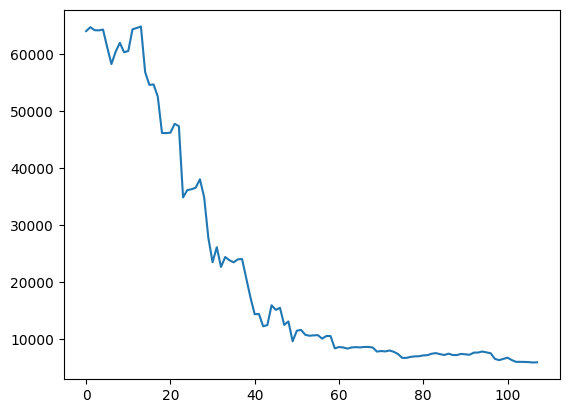

In [319]:
plt.plot(history[1:])

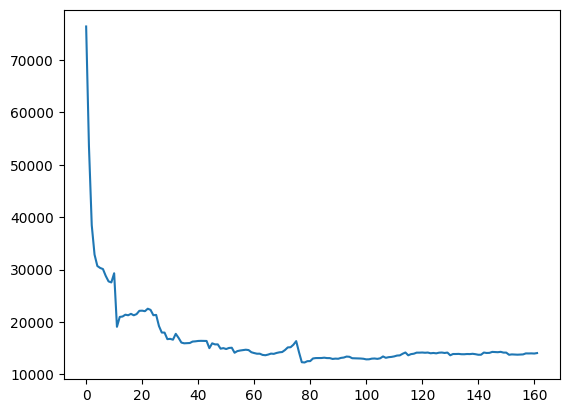

In [314]:
plt.plot(history[1:])

In [85]:
import pickle
with open(file_path+'/model.pkl', 'wb') as outp:
    pickle.dump(model, outp, pickle.HIGHEST_PROTOCOL)

In [12]:
import numpy as np
import scipy.stats
from typing import Tuple, Union
from emukit.core.acquisition import Acquisition
from emukit.core.interfaces import IDifferentiable, IJointlyDifferentiable, IModel, IModelWithNoise


class CrossEntropy(Acquisition):
    def __init__(self, model: Union[IModel, IDifferentiable],space: ParameterSpace, jitter: float = 0.0) -> None:
        """
        For a given input, this acquisition computes the improvement over the current best observed value in
        expectation. For more information see:

        Efficient Global Optimization of Expensive Black-Box Functions
        Jones, Donald R. and Schonlau, Matthias and Welch, William J.
        Journal of Global Optimization

        :param model: model that is used to compute the improvement.
        :param jitter: parameter to encourage extra exploration.
        """

        self.model = model
        self.jitter = jitter
        self.space = space

    def evaluate(self, X: np.ndarray) -> np.ndarray:
        ces = []
        for x in X:
            #print(x.shape,x)
            predicted_mu, predicted_var = self.model.predict(np.array([x]))
            predicted_mu = predicted_mu[0]
            predicted_var = predicted_var[0]
            observed_mu = (np.sqrt(np.sum((self.model.X-x)**2,axis=-1))/(np.sqrt(np.sum((self.model.X-x)**2,axis=-1))).sum()).dot(self.model.Y)
            observed_x2 = (np.sqrt(np.sum((self.model.X-x)**2,axis=-1))/(np.sqrt(np.sum((self.model.X-x)**2,axis=-1))).sum()).dot(self.model.Y**2)
            observed_std = np.sqrt(observed_x2-observed_mu**2)
            predicted_std = np.sqrt(predicted_var)
            # print(predicted_mu, predicted_std, observed_mu, observed_std)
            temp = np.linspace(0, 1000, 1000)
            pk = scipy.stats.norm.pdf(temp, loc=predicted_mu, scale=predicted_std)/scipy.stats.norm.pdf(temp, loc=predicted_mu, scale=predicted_std).sum()
            qk = scipy.stats.norm.pdf(temp, loc=observed_mu, scale=observed_std)/scipy.stats.norm.pdf(temp, loc=observed_mu, scale=observed_std).sum()
            ce = entropy(pk, base=2) + entropy(pk, qk, base=2)
            ces.append([ce])
        return np.array(ces)

    def debug(self, X: np.ndarray) -> np.ndarray:
        ces = []
        for x in X:
            #print(x.shape,x)
            predicted_mu, predicted_var = self.model.predict(np.array([x]))
            predicted_mu = predicted_mu[0]
            predicted_var = predicted_var[0]
            observed_mu = (np.sqrt(np.sum((self.model.X-x)**2,axis=-1))/(np.sqrt(np.sum((self.model.X-x)**2,axis=-1))).sum()).dot(self.model.Y)
            observed_x2 = (np.sqrt(np.sum((self.model.X-x)**2,axis=-1))/(np.sqrt(np.sum((self.model.X-x)**2,axis=-1))).sum()).dot(self.model.Y**2)
            observed_std = np.sqrt(observed_x2-observed_mu**2)
            predicted_std = np.sqrt(predicted_var)
            #print(predicted_mu, predicted_std, observed_mu, observed_std)
            print(x,predicted_mu, predicted_var)
            temp = np.linspace(0, 1000, 1000)
            pk = scipy.stats.norm.pdf(temp, loc=predicted_mu, scale=predicted_std)/scipy.stats.norm.pdf(temp, loc=predicted_mu, scale=predicted_std).sum()
            qk = scipy.stats.norm.pdf(temp, loc=observed_mu, scale=observed_std)/scipy.stats.norm.pdf(temp, loc=observed_mu, scale=observed_std).sum()
            ce = entropy(pk, base=2) + entropy(pk, qk, base=2)
            ces.append([ce])
        return np.array(ces)


    @property
    def has_gradients(self) -> bool:
        """Returns that this acquisition has gradients"""
        return False

    def _get_model_predictions(self, x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Get model predictions for the function values at given input locations."""
        return self.model.predict(x)

    def _get_y_minimum(self) -> np.ndarray:
        """Return the minimum value in the samples observed so far."""
        return np.min(self.model.Y, axis=0)


In [ ]:
space = ParameterSpace([ContinuousParameter('size', 0, 10),
                            ContinuousParameter('speed', 0, 10),
                            ContinuousParameter('vision', 0, 10),
                            ContinuousParameter('aggression', 0, 10)])
design = RandomDesign(space) # Collect random points
X = design.get_samples(1000)